# GoPro Video Reconstruction with SHRED and Neural CDE

This notebook demonstrates video reconstruction using:
- **SHRED**: Sensor-based Hyperbolic-Equation Decoder
- **Neural CDE**: Neural Controlled Differential Equations

All data processing and visualization is handled by utility modules.

In [94]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.random as jr
import importlib

# Local utilities - with reload to pick up changes
import utils.data_processing
import utils.visualization
import utils.mlflow_utils
import utils.models_diffrax

importlib.reload(utils.data_processing)
importlib.reload(utils.visualization)
importlib.reload(utils.mlflow_utils)
importlib.reload(utils.models_diffrax)

from utils.data_processing import GoproDataset, rmse
from utils.visualization import (
    plot_singular_values, plot_sensor_locations, plot_training_curves,
    plot_comparison, create_comparison_gif, create_pod_coefficient_gif,
    plot_model_comparison
)
from utils.mlflow_utils import ModelTracker, load_model
from utils.models_diffrax import SHRED, NeuralCDE, fit_SHRED, fit_CDE

plt.style.use('default')
print("Imports complete!")

MLflow not installed. Using local file-based tracking.
Imports complete!


## 1. Configuration

In [50]:
# CONFIGURATION
CONFIG = {
    # Data
    'data_dir': 'data',
    'nvideos': 2,
    'nsensors': 3,
    'lag': 150,
    'k': 100,  # POD modes
    'threshold': 0.5,
    'seed': 0,
    
    # Model
    'hidden_size': 64,
    'depth': 2,
    'hidden_state_cde': 20,
    'decoder_sizes': [350, 400],
    
    # Training
    'epochs': 200,
    'batch_size': 64,
    'learning_rate': 1e-3,
    'early_stopping': 200,
    
    # MLflow
    'experiment_name': 'gopro_reconstruction',
    'run_name': 'shred_cde_comparison',
}

print("Configuration loaded!")

Configuration loaded!


## 2. Load and Preprocess Data

In [88]:
# LOAD DATA
dataset = GoproDataset(
    data_dir=CONFIG['data_dir'],
    nvideos=CONFIG['nvideos'],
    nsensors=CONFIG['nsensors'],
    lag=CONFIG['lag'],
    k=CONFIG['k'],
    threshold=CONFIG['threshold'],
    seed=CONFIG['seed']
)

print(f"\nDataset loaded:")
print(f"  Videos: {dataset.nvideos} x {dataset.nframes} frames")
print(f"  Frame size: {dataset.Lx} x {dataset.Ly}")
print(f"  Sensors: {dataset.nsensors}")
print(f"  Lag: {dataset.lag}")
print(f"  POD modes: {dataset.k}")


Dataset loaded:
  Videos: 2 x 1077 frames
  Frame size: 400 x 504
  Sensors: 3
  Lag: 150
  POD modes: 100


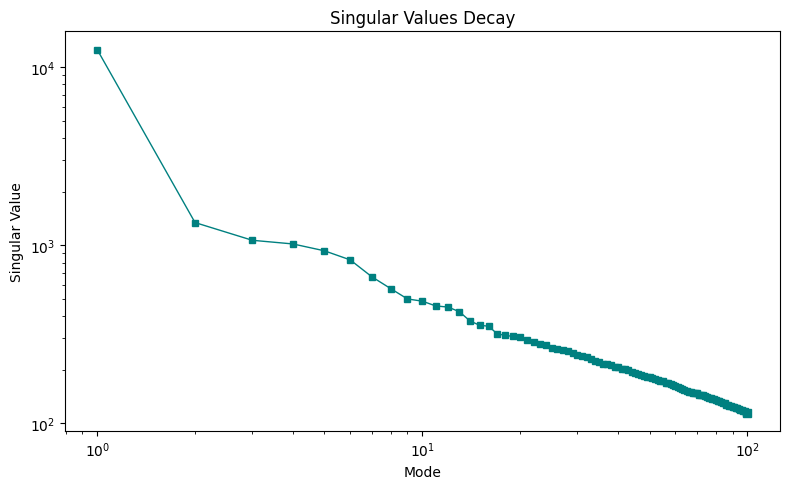

In [52]:
# PLOT SINGULAR VALUES
plot_singular_values(dataset.S, k=dataset.k)

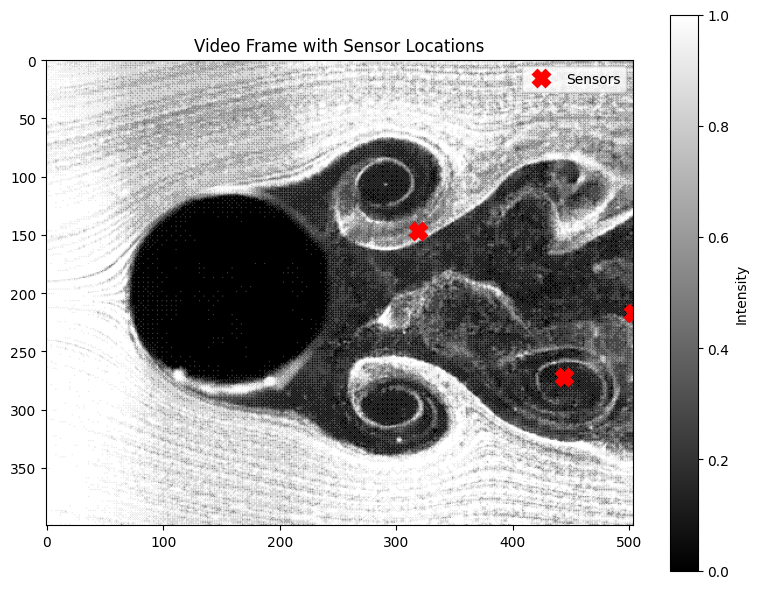

In [53]:
# SHOW SENSOR LOCATIONS
plot_sensor_locations(
    dataset.videos_flat[1],  # Use frame 1
    dataset.sensors_coordinates,
    dataset.Lx, dataset.Ly
)

In [54]:
# RECONSTRUCTION ERRORS
errors = dataset.compute_reconstruction_error()
print("POD Reconstruction Errors:")
for key, value in errors.items():
    print(f"  {key}: {value:.4f}%")

POD Reconstruction Errors:
  train_pod: 11.2569%
  valid_pod: 12.0412%
  test_pod: 12.0656%


In [89]:
# GET DATASETS
train_data_cde, valid_data_cde, test_data_cde = dataset.get_cde_data()
train_data_shred, valid_data_shred, test_data_shred = dataset.get_shred_data()

print(f"\nCDE Data shapes:")
print(f"  Train: ts={train_data_cde['ts'].shape}, Y={train_data_cde['Y'].shape}")
print(f"  Valid: ts={valid_data_cde['ts'].shape}, Y={valid_data_cde['Y'].shape}")
print(f"  Test:  ts={test_data_cde['ts'].shape}, Y={test_data_cde['Y'].shape}")

print(f"\nSHRED Data shapes:")
print(f"  Train: S_i={train_data_shred['S_i'].shape}, Y={train_data_shred['Y'].shape}")
print(f"  Valid: S_i={valid_data_shred['S_i'].shape}, Y={valid_data_shred['Y'].shape}")
print(f"  Test:  S_i={test_data_shred['S_i'].shape}, Y={test_data_shred['Y'].shape}")


CDE Data shapes:
  Train: ts=(1484, 150), Y=(1484, 100)
  Valid: ts=(185, 150), Y=(185, 100)
  Test:  ts=(187, 150), Y=(187, 100)

SHRED Data shapes:
  Train: S_i=(1484, 150, 3), Y=(1484, 100)
  Valid: S_i=(185, 150, 3), Y=(185, 100)
  Test:  S_i=(187, 150, 3), Y=(187, 100)


## 3. Initialize Models and Tracker

In [56]:
# INITIALIZE MLFLOW TRACKER
tracker = ModelTracker(
    experiment_name=CONFIG['experiment_name'],
    use_mlflow=True  # Set to False if MLflow not installed
)

# Start run
run_id = tracker.start_run(run_name=CONFIG['run_name'])
print(f"Run ID: {run_id}")

# Log configuration
tracker.log_params(CONFIG)
tracker.log_params(dataset.get_config())

Run ID: shred_cde_comparison_20260206_104344


In [95]:
# CREATE MODELS
output_size = train_data_shred['Y'].shape[-1]

model_key_shred, model_key_cde = jr.split(jr.PRNGKey(CONFIG['seed']), 2)

shred = SHRED(
    dataset.nsensors, 
    output_size,
    hidden_size=CONFIG['hidden_size'],
    hidden_layers=CONFIG['depth'],
    decoder_sizes=CONFIG['decoder_sizes'],
    activation=jax.nn.relu,
    key=model_key_shred
)

cde = NeuralCDE(
    dataset.nsensors,
    output_size=output_size,
    hidden_state=CONFIG['hidden_state_cde'],
    width_size=CONFIG['hidden_size'],
    depth=CONFIG['depth'],
    activation_cde=jax.nn.relu,
    activation_decoder=jax.nn.relu,
    decoder_sizes=CONFIG['decoder_sizes'],
    key=model_key_cde
)

print(f"Models created:")
print(f"  SHRED: input={dataset.nsensors}, output={output_size}")
print(f"  Neural CDE: input={dataset.nsensors}, hidden={CONFIG['hidden_state_cde']}, output={output_size}")

Models created:
  SHRED: input=3, output=100
  Neural CDE: input=3, hidden=20, output=100


## 4. Train SHRED Model

In [91]:
# TRAIN SHRED
print("Training SHRED model...")
shred, train_losses_shred, valid_losses_shred = fit_SHRED(
    shred,
    train_data_shred,
    valid_data_shred,
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    lr=CONFIG['learning_rate'],
    early_stopping=CONFIG['early_stopping']
)

# Log training history
tracker.log_training_history(train_losses_shred, valid_losses_shred, 'shred')
tracker.log_metrics({
    'shred_final_train_loss': train_losses_shred[-1],
    'shred_final_valid_loss': valid_losses_shred[-1],
    'shred_best_valid_loss': min(valid_losses_shred)
})

print(f"\nSHRED Training complete:")
print(f"  Final train loss: {train_losses_shred[-1]:.6f}")
print(f"  Final valid loss: {valid_losses_shred[-1]:.6f}")
print(f"  Best valid loss: {min(valid_losses_shred):.6f}")

Training SHRED model...
Epoch 200/200 | Train 3.6604e-02 | Valid 4.1150e-02 | Time 1.18s | Patience 0/2000
Training done: Train loss = 3.6604e-02 | Valid loss = 4.1150e-02

SHRED Training complete:
  Final train loss: 0.036604
  Final valid loss: 0.041150
  Best valid loss: 0.041150


## 5. Train Neural CDE Model

In [96]:
# TRAIN NEURAL CDE
print("Training Neural CDE model...")
cde, train_losses_cde, valid_losses_cde = fit_CDE(
    cde,
    train_data_cde,
    valid_data_cde,
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    lr=CONFIG['learning_rate'],
    early_stopping=CONFIG['early_stopping']
)

# Log training history
tracker.log_training_history(train_losses_cde, valid_losses_cde, 'cde')
tracker.log_metrics({
    'cde_final_train_loss': train_losses_cde[-1],
    'cde_final_valid_loss': valid_losses_cde[-1],
    'cde_best_valid_loss': min(valid_losses_cde)
})

print(f"\nNeural CDE Training complete:")
print(f"  Final train loss: {train_losses_cde[-1]:.6f}")
print(f"  Final valid loss: {valid_losses_cde[-1]:.6f}")
print(f"  Best valid loss: {min(valid_losses_cde):.6f}")

Training Neural CDE model...
Epoch 200/200 | Train 9.2534e-01 | Valid 1.2271e+00 | Time 11.79s | Patience 7/2000
Training done: Train loss = 9.2534e-01 | Valid loss = 1.2271e+00

Neural CDE Training complete:
  Final train loss: 0.925339
  Final valid loss: 1.227093
  Best valid loss: 1.173462


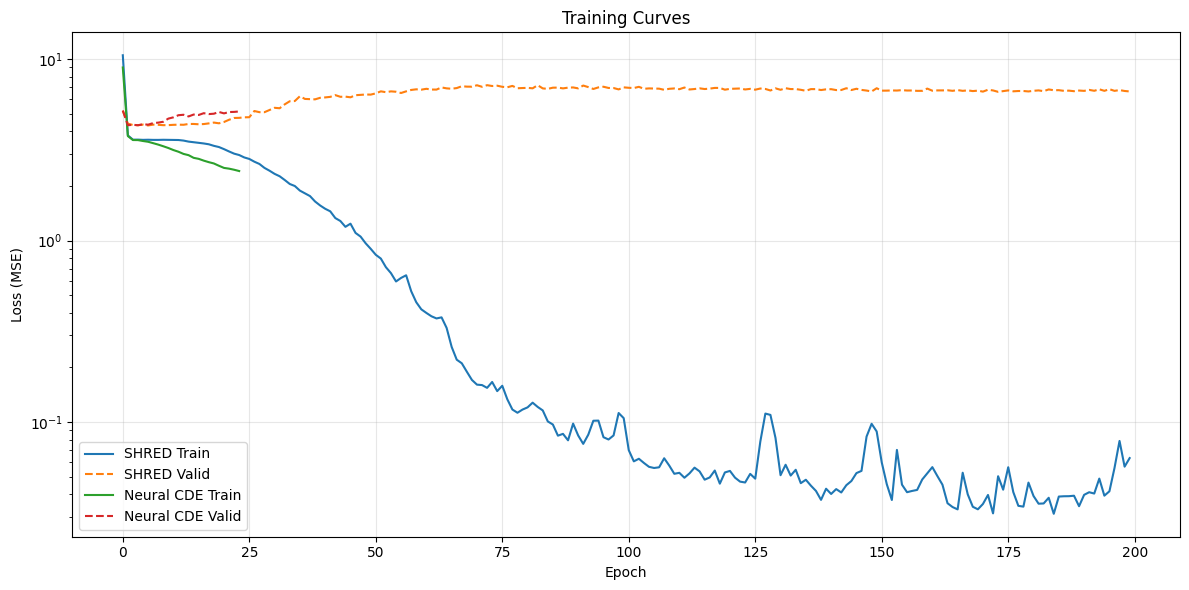

In [ ]:
# PLOT TRAINING CURVES
plot_training_curves(
    [train_losses_shred, train_losses_cde],
    [valid_losses_shred, valid_losses_cde],
    labels=['SHRED', 'Neural CDE']
)

## 6. Evaluate Models

In [92]:
# EVALUATE SHRED
y_hat_train_shred = jax.vmap(shred)(train_data_shred['S_i'])
y_hat_valid_shred = jax.vmap(shred)(valid_data_shred['S_i'])
y_hat_test_shred = jax.vmap(shred)(test_data_shred['S_i'])

# Transform back to video space
preds_train_shred = dataset.inverse_transform(y_hat_train_shred)
preds_valid_shred = dataset.inverse_transform(y_hat_valid_shred)
preds_test_shred = dataset.inverse_transform(y_hat_test_shred)

train_Y_shred = dataset.inverse_transform(train_data_shred['Y'])
valid_Y_shred = dataset.inverse_transform(valid_data_shred['Y'])
test_Y_shred = dataset.inverse_transform(test_data_shred['Y'])

rmse_train_shred = rmse(preds_train_shred, train_Y_shred) * 100
rmse_valid_shred = rmse(preds_valid_shred, valid_Y_shred) * 100
rmse_test_shred = rmse(preds_test_shred, test_Y_shred) * 100

print(f"SHRED RMSE:")
print(f"  Train: {rmse_train_shred:.4f}%")
print(f"  Valid: {rmse_valid_shred:.4f}%")
print(f"  Test:  {rmse_test_shred:.4f}%")

tracker.log_metrics({
    'shred_rmse_train': rmse_train_shred,
    'shred_rmse_valid': rmse_valid_shred,
    'shred_rmse_test': rmse_test_shred
})

SHRED RMSE:
  Train: 1.7968%
  Valid: 1.9912%
  Test:  2.0719%


In [97]:
# EVALUATE NEURAL CDE
y_hat_train_cde = jax.vmap(cde)(train_data_cde['ts'], train_data_cde['coeffs'])
y_hat_valid_cde = jax.vmap(cde)(valid_data_cde['ts'], valid_data_cde['coeffs'])
y_hat_test_cde = jax.vmap(cde)(test_data_cde['ts'], test_data_cde['coeffs'])

# Transform back to video space
preds_train_cde = dataset.inverse_transform(y_hat_train_cde)
preds_valid_cde = dataset.inverse_transform(y_hat_valid_cde)
preds_test_cde = dataset.inverse_transform(y_hat_test_cde)

train_Y_cde = dataset.inverse_transform(train_data_cde['Y'])
valid_Y_cde = dataset.inverse_transform(valid_data_cde['Y'])
test_Y_cde = dataset.inverse_transform(test_data_cde['Y'])

rmse_train_cde = rmse(preds_train_cde, train_Y_cde) * 100
rmse_valid_cde = rmse(preds_valid_cde, valid_Y_cde) * 100
rmse_test_cde = rmse(preds_test_cde, test_Y_cde) * 100

print(f"Neural CDE RMSE:")
print(f"  Train: {rmse_train_cde:.4f}%")
print(f"  Valid: {rmse_valid_cde:.4f}%")
print(f"  Test:  {rmse_test_cde:.4f}%")

tracker.log_metrics({
    'cde_rmse_train': rmse_train_cde,
    'cde_rmse_valid': rmse_valid_cde,
    'cde_rmse_test': rmse_test_cde
})

Neural CDE RMSE:
  Train: 10.2668%
  Valid: 11.2378%
  Test:  12.0030%


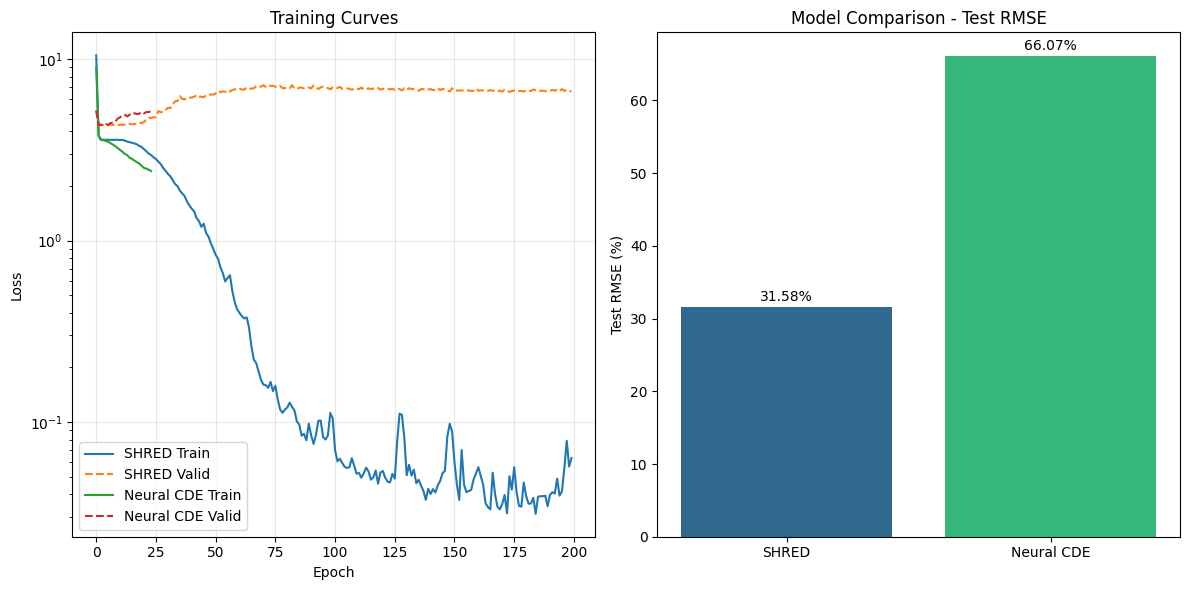

In [63]:
# MODEL COMPARISON
models_results = {
    'SHRED': {
        'train_loss': train_losses_shred,
        'valid_loss': valid_losses_shred,
        'test_rmse': rmse_test_shred
    },
    'Neural CDE': {
        'train_loss': train_losses_cde,
        'valid_loss': valid_losses_cde,
        'test_rmse': rmse_test_cde
    }
}

plot_model_comparison(models_results)

## 7. Visualize Predictions

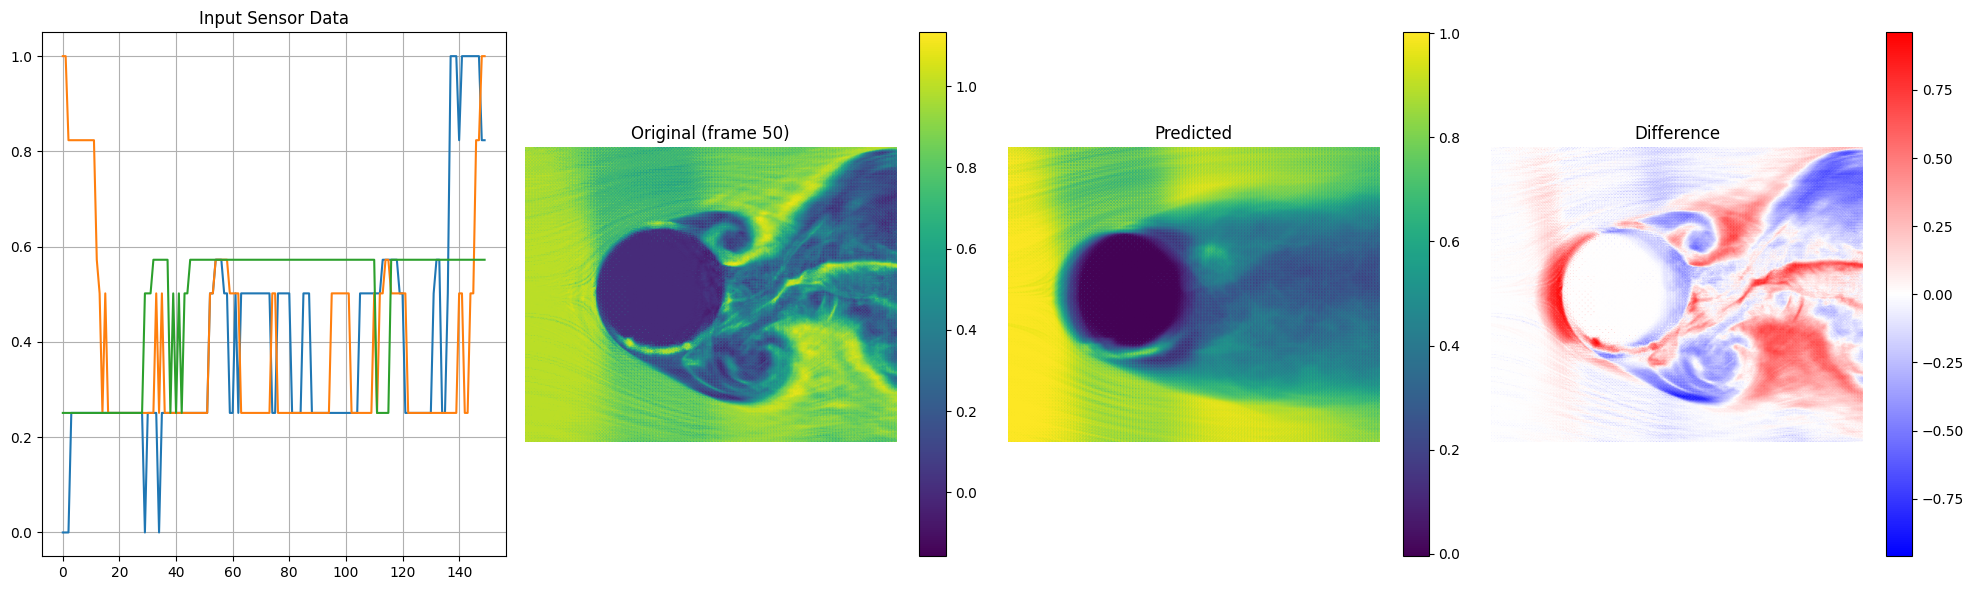

In [64]:
# PLOT SINGLE COMPARISON - SHRED
idx = 50
plot_comparison(
    test_Y_shred, preds_test_shred,
    dataset.Lx, dataset.Ly,
    idx=idx,
    input_data=test_data_shred['S_i']
)

Saved GIF to shred_comparison.gif


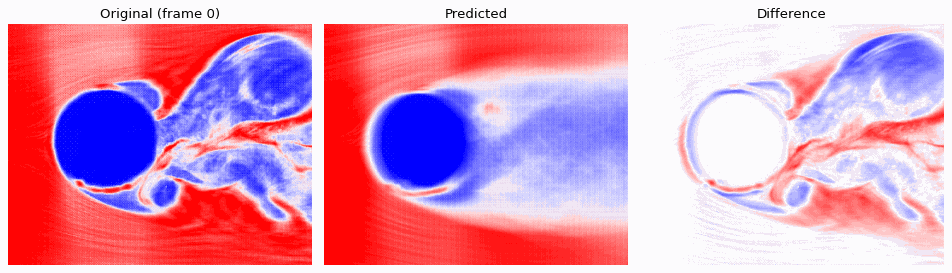

In [65]:
# CREATE SHRED ANIMATION
shred_gif = create_comparison_gif(
    test_Y_shred.reshape(-1, dataset.Lx, dataset.Ly),
    preds_test_shred.reshape(-1, dataset.Lx, dataset.Ly),
    dataset.Lx, dataset.Ly,
    save_path='shred_comparison.gif',
    start_frame=0,
    n_frames=50,
    frame_duration=100,
    show=True
)
tracker.log_artifact(shred_gif)

Saved GIF to cde_comparison.gif


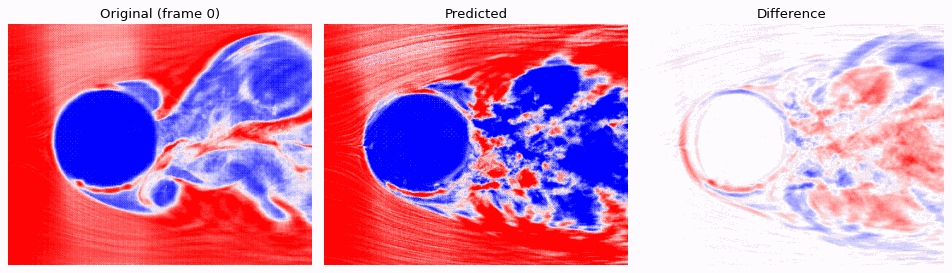

In [66]:
# CREATE CDE ANIMATION
cde_gif = create_comparison_gif(
    test_Y_cde.reshape(-1, dataset.Lx, dataset.Ly),
    preds_test_cde.reshape(-1, dataset.Lx, dataset.Ly),
    dataset.Lx, dataset.Ly,
    save_path='cde_comparison.gif',
    start_frame=0,
    n_frames=50,
    frame_duration=100,
    show=True
)
tracker.log_artifact(cde_gif)

Saved GIF to shred_coefficients.gif


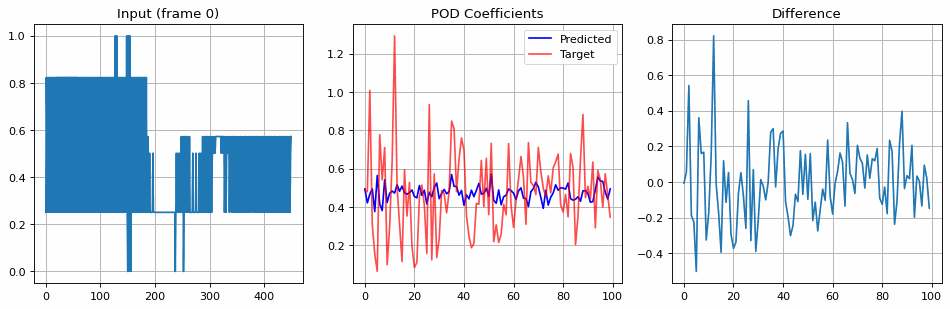

In [67]:
# CREATE POD COEFFICIENT ANIMATION
coeff_gif = create_pod_coefficient_gif(
    test_data_shred['S_i'],
    y_hat_test_shred,
    test_data_shred['Y'],
    save_path='shred_coefficients.gif',
    start_frame=0,
    n_frames=50,
    frame_duration=100,
    show=True
)
tracker.log_artifact(coeff_gif)

## 8. Save Models

In [68]:
# SAVE SHRED MODEL
tracker.save_model(
    shred, 
    'shred_model',
    additional_data={
        'config': CONFIG,
        'train_losses': train_losses_shred,
        'valid_losses': valid_losses_shred,
        'test_rmse': rmse_test_shred
    }
)

# SAVE CDE MODEL
tracker.save_model(
    cde,
    'cde_model',
    additional_data={
        'config': CONFIG,
        'train_losses': train_losses_cde,
        'valid_losses': valid_losses_cde,
        'test_rmse': rmse_test_cde
    }
)

print("\nModels saved successfully!")

Model saved: shred_model
Model saved: cde_model

Models saved successfully!


In [69]:
# END MLFLOW RUN
tracker.end_run()
print(f"Experiment tracking complete. Run ID: {run_id}")

Experiment tracking complete. Run ID: shred_cde_comparison_20260206_104344


## 9. Summary

In [70]:
# PRINT SUMMARY
print("="*60)
print("EXPERIMENT SUMMARY")
print("="*60)
print(f"\nRun ID: {run_id}")
print(f"\nData:")
print(f"  Videos: {dataset.nvideos} x {dataset.nframes} frames")
print(f"  Sensors: {dataset.nsensors}")
print(f"  Lag: {dataset.lag}")
print(f"  POD modes: {dataset.k}")
print(f"\nSHRED Results:")
print(f"  Test RMSE: {rmse_test_shred:.4f}%")
print(f"  Best Valid Loss: {min(valid_losses_shred):.6f}")
print(f"\nNeural CDE Results:")
print(f"  Test RMSE: {rmse_test_cde:.4f}%")
print(f"  Best Valid Loss: {min(valid_losses_cde):.6f}")
print("\n" + "="*60)

EXPERIMENT SUMMARY

Run ID: shred_cde_comparison_20260206_104344

Data:
  Videos: 2 x 1077 frames
  Sensors: 3
  Lag: 150
  POD modes: 100

SHRED Results:
  Test RMSE: 31.5753%
  Best Valid Loss: 4.307288

Neural CDE Results:
  Test RMSE: 66.0723%
  Best Valid Loss: 4.319586

